In [1]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split

df = pd.read_csv('../../res/tp2/reviews_sentiment.csv', sep=';')

df.head()


,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,23,negative,negative,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,negative,negative,1,-0.586187
2,Es muy buena lo recomiendo,Andres e puto amoooo,4,NaN,negative,1,-0.602240
3,Version antigua,Me gustana mas la version anterior esta es mas...,17,NaN,negative,1,-0.616271
4,Esta bien,Sin ser la biblia.... Esta bien,6,negative,negative,1,-0.651784


In [2]:
# 
df.columns = ['title', 'review', 'wordcount', 'titleSentiment', 'textSentiment', 'rating', 'value']

# Removemos las variable que no tienen importancia
df.drop('title', inplace=True, axis=1)
df.drop('review', inplace=True, axis=1)
df.drop('textSentiment', inplace=True, axis=1)


In [3]:
# Removemos valores NaN
df = df.drop(df[df['titleSentiment'].isnull()].index)

#  Como necesitamos que las variables sean numericas, vamos a cambiar los valores de negative y positive por {-1, 1}

df.loc[df.titleSentiment == 'negative', 'titleSentiment'] = -2
df.loc[df.titleSentiment == 'positive', 'titleSentiment'] = 2

df.head()

,wordcount,titleSentiment,rating,value
0,23,-2,1,-0.486389
1,20,-2,1,-0.586187
4,6,-2,1,-0.651784
5,8,2,1,-0.720443
6,23,2,1,-0.726825


In [4]:
# Los comentarios valorados con 1 estrella, ¿que cantidad promedio de palabras tienen?
word_count = 0
count = 0
for index, row in df.iterrows():    
    if (row['rating'] == 1):
        count += 1
        word_count += row['wordcount']

mean_words = word_count / count
print(f'El promedio de palabras para los comentarios valorados con 1 estrella es {mean_words}')

El promedio de palabras para los comentarios valorados con 1 estrella es 12.470588235294118


In [5]:
# Dividir el conjunto de datos en un conjunto de entrenamiento y otro de prueba
train, test = train_test_split(df, test_size=0.2)

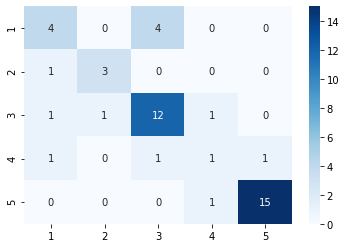

In [10]:
# Aplicar los algoritmos K-NN y K-NN con distancias pesadas para clasificar las opiniones, utilizando como variable objetivo la variable rating y como variables
# explicativas las variables wordcount, titleSentiment, value y con k = 5 (k se podria pasar por parametro)

def calc_euclidean_distance(record_1, record_2):
    distance = 0
    for col in df.columns:
        distance += math.pow(record_1[col] - record_2[col], 2) 
    return math.sqrt(distance)
    
# Returns a dataframe/collection with k nearest neighbours sorted by distance asc
def get_k_nearest_neighbours(record, k):
    if (k >= len(train)):
        raise ValueError("K debe ser menor a N")
    
    # Creamos un dataframe vacio
    distance_df = pd.DataFrame(columns = ['distance', 'rating'])
    
    # Calculamos d(record, row) para cada fila del train dataframe
    for index, row in train.iterrows():

        distance = calc_euclidean_distance(record, row)
        distance_df.loc[index] = [distance, row['rating']]
    
    return distance_df.sort_values('distance').head(k)


# Teniendo un dataframe con los k vecinos mas cercanos ordenados de menor a mayor distancia, queremos ver que clase es la ganadora
def classify_rating_w_neighbours(k_neigh_df):
    return k_neigh_df.mode()['rating'][0]

# Si d(xq, xi) = 0, entonces f (xq) = f (xi) y si son muchos los valores cercanos cuya distancia es cero, 
# se le asigna el valor que mas aparece
def classify_rating_w_neighbours_weighted(k_neigh_df):
    rating_weight = { rating : 0 for rating in range(1,6) }
    min_dist_rating = { rating : 0 for rating in range(1,6) }
    
    for index, row in k_neigh_df.iterrows():
        distance = row['distance']
        rating = row['rating']
        
        if (math.isclose(distance, 0, abs_tol=0.0001)):
            min_dist_rating[rating] += 1 
        else:
            w = 1 / math.pow(distance, 2)
            rating_weight[rating] += w
    
    # Se encontraron valores con distancia 0
    if (any(elem > 0 for elem in  min_dist_rating.values())):
        return max(min_dist_rating, key=lambda key:  min_dist_rating[key])
        
    return max(rating_weight, key=lambda key: rating_weight[key])

def get_confusion_matrix_df(k, weighted=False):
    confusion_matrix = { rating : {} for rating in range(1,6) }
    columns = []
    for key in confusion_matrix.keys():
        columns.append(key)
        confusion_matrix[key] = { rating : 0 for rating in range(1,6) }

    for index, row in test.iterrows():
        record_neigh_df = get_k_nearest_neighbours(row, k)
        classified_rating = classify_rating_w_neighbours_weighted(record_neigh_df) if weighted else classify_rating_w_neighbours(record_neigh_df)
        rating = row['rating']
        confusion_matrix[rating][classified_rating] += 1
        
    confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
    confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)
    return confusion_df

import numpy as np

def get_metrics_df(confusion_df):
    rating_metrics = { rating : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0} for rating in range(1,6) }
    ratings = [1,2,3,4,5]
    for i, rating in enumerate(ratings):
        
        # Metricas simples
        tp = confusion_df.iloc[i,i]
        tn = sum(np.diag(confusion_df)) - tp
        fn = sum(confusion_df.loc[rating]) - tp
        fp = sum(confusion_df[rating]) - tp

        rating_metrics[rating]['tp'] = tp
        rating_metrics[rating]['tn'] = tn
        rating_metrics[rating]['fp'] = fp
        rating_metrics[rating]['fn'] = fn

        # Metricas compuestas
        rating_metrics[rating]['accuracy'] = (tp + tn) / (tp + tn + fn + fp)
        rating_metrics[rating]['precision'] = tp / (tp + fp)
        rating_metrics[rating]['recall'] = tp / (tp + fn)
        rating_metrics[rating]['f1'] = (2 * rating_metrics[rating]['precision'] * rating_metrics[rating]['recall']) / (rating_metrics[rating]['precision'] + rating_metrics[rating]['recall'])

    metric_cols = ['tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'f1']
    metrics_df = { key : list(rating_metrics[key].values()) for key in rating_metrics.keys() }    
    metrics_df = pd.DataFrame.from_dict(rating_metrics, orient='index', columns=metric_cols)
    
    return metrics_df

import seaborn as sns

# K Neighbours
k = 5

# Matriz de confusion y metricas utilizando KNN 
confusion_df = get_confusion_matrix_df(k, False)
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')   

In [11]:
knn_metrics = get_metrics_df(confusion_df)
knn_metrics

,tp,tn,fp,fn,accuracy,precision,recall,f1
1,4,31,3,4,0.833333,0.571429,0.5000,0.533333
2,3,32,1,1,0.945946,0.750000,0.7500,0.750000
3,12,23,5,3,0.813953,0.705882,0.8000,0.750000
4,1,34,2,3,0.875000,0.333333,0.2500,0.285714
5,15,20,1,1,0.945946,0.937500,0.9375,0.937500


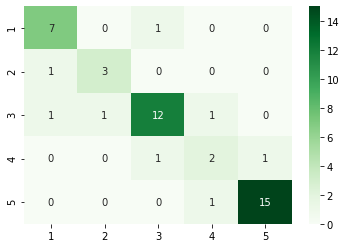

In [12]:
weighted_confusion_df = get_confusion_matrix_df(k, weighted=True)
sns.heatmap(weighted_confusion_df,cmap='Greens', annot=True, fmt='g')   

In [ ]:
weigthed_knn_metrics = get_metrics_df(weighted_confusion_df)
weigthed_knn_metrics
